In [8]:
### MY ANALYTICAL SOLUTION TO THE SILICON DETECTOR SIMULATION ###

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy as sp

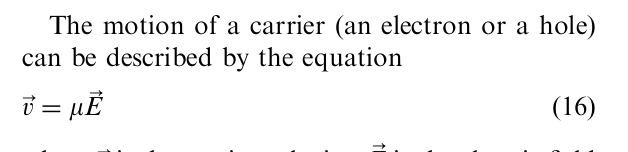

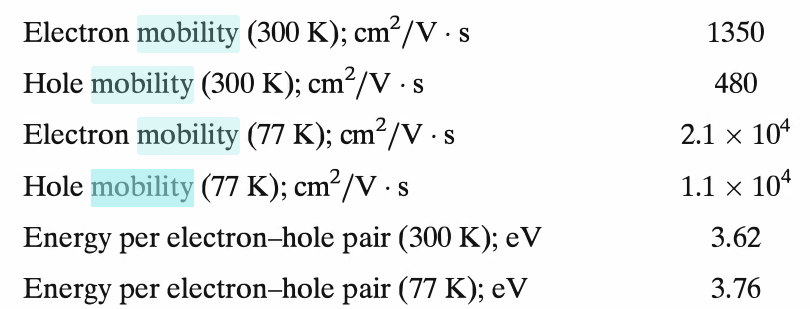

In [10]:
# in m^2/Vs so be careful!
MOBILITIES = {
    'electron': {
        'room temperature': -1350 * 1e-4,
        'cryogenic': -2.1
    },
    'hole': {
        'room temperature': 480 * 1e-4,
        'cryogenic': 1.1
    }
}

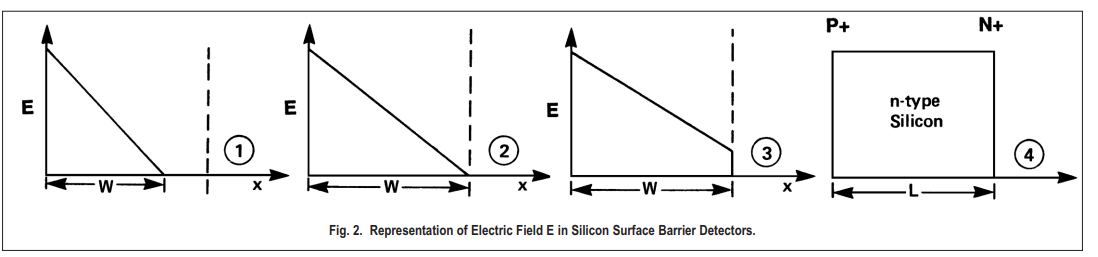

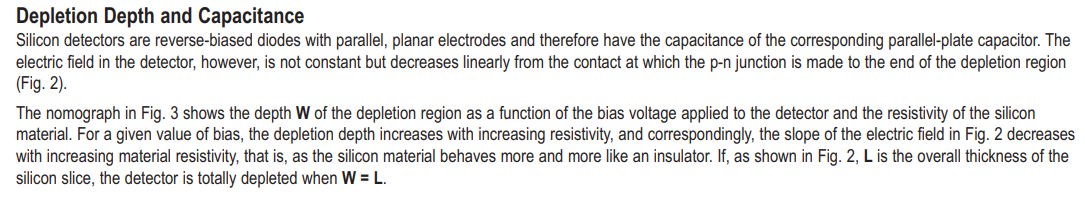

### Derivation of Electric Field Slope from Minimum Bias Voltage Required for Full Alpha Events on Back of Detector ###
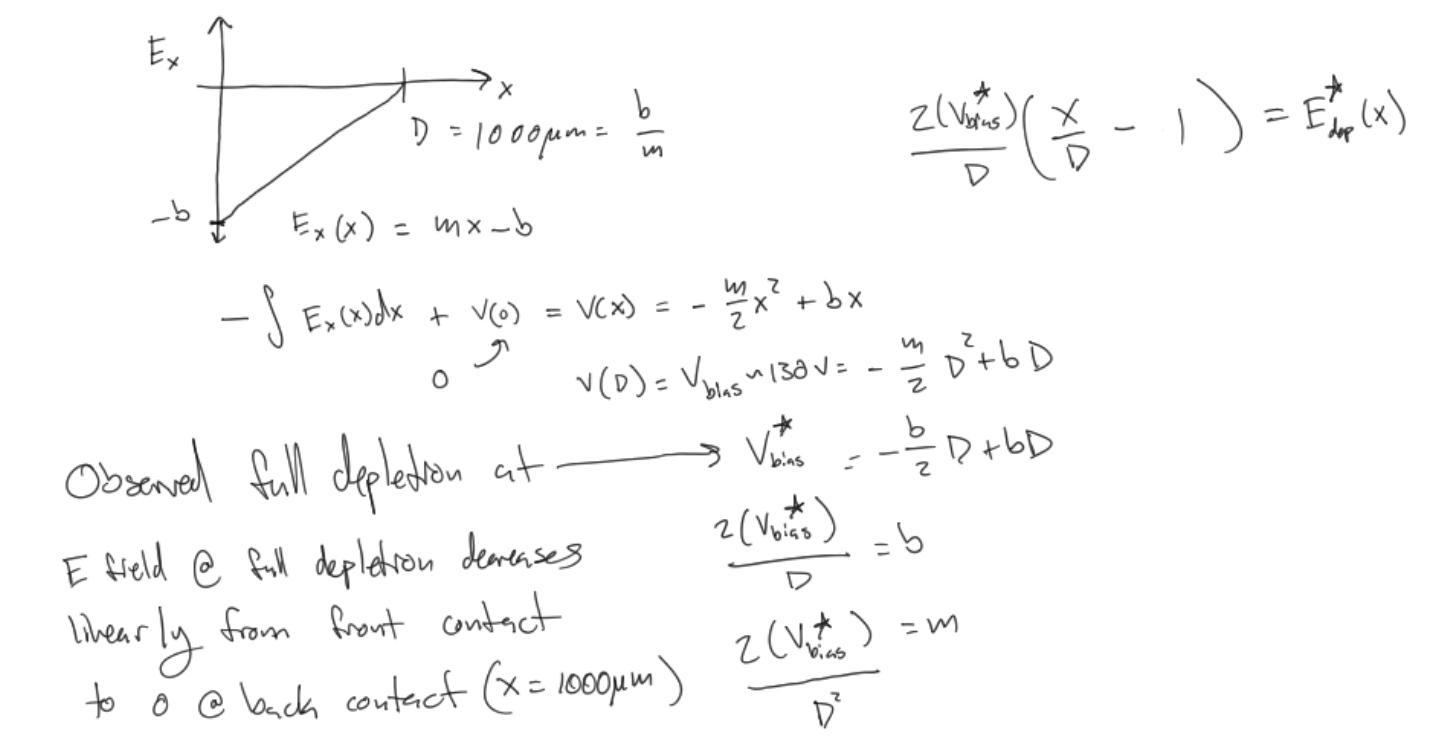

### Derivation of Spatial Charge Density of Fully Depleted Si Bulk ###

This space charge will remain constant even if we increase surface charge on both contacts (raise bias voltage)

This means slope of field strength remains the same for over-depletion

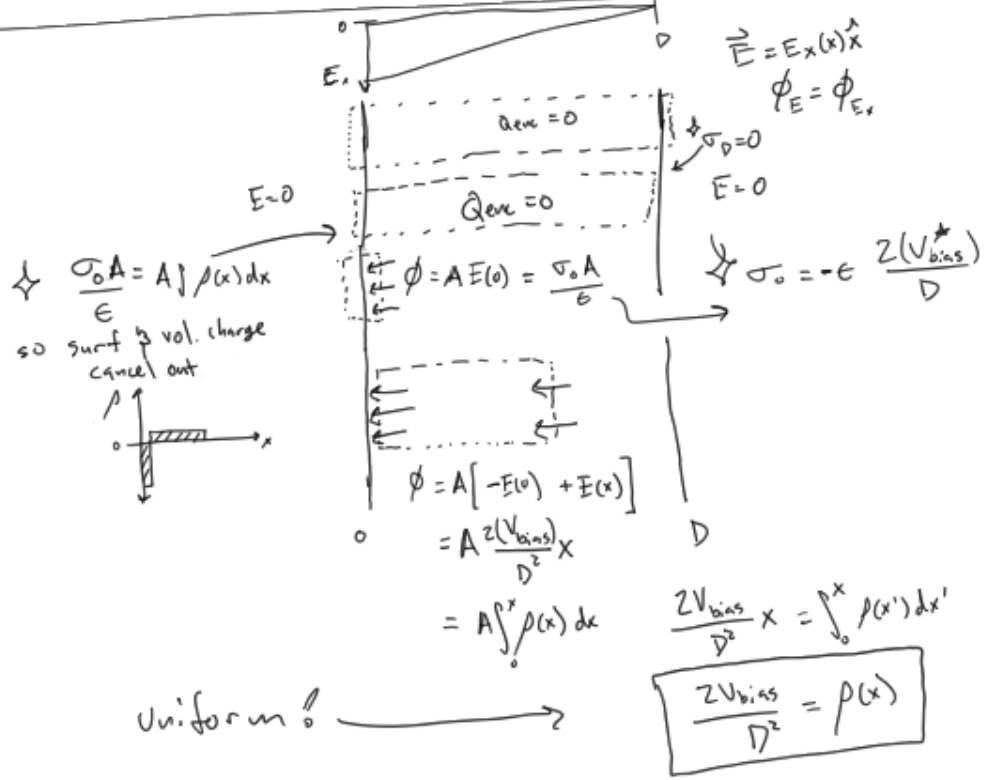

Now we'll make a large (but I think valid) assumtion that the field slope will also not change for under-depletion. This assumes that the boundary of the uniform bulk charge density distribution simply shrinks back towards the detector front (ground) as bias voltage is decreased, and the actual density does not change.

This assumption allows us to reproduce the behavior described in the Ortec Manual for under- and over-depletion voltages. 


In [11]:
xg = 0
xv = 1e-3 # m
DET_DEPTH = (xv - xg) # m
V_DEPLETION = 120 # V

In [12]:
field_slope = 2 * V_DEPLETION / DET_DEPTH**2 # V/m^2
field_intercept = -2 * V_DEPLETION / DET_DEPTH # V/m
print(f'Field slope: {field_slope:.2e} V/m^2, Field intercept: {field_intercept:.2e} V/m')  

Field slope: 2.40e+08 V/m^2, Field intercept: -2.40e+05 V/m


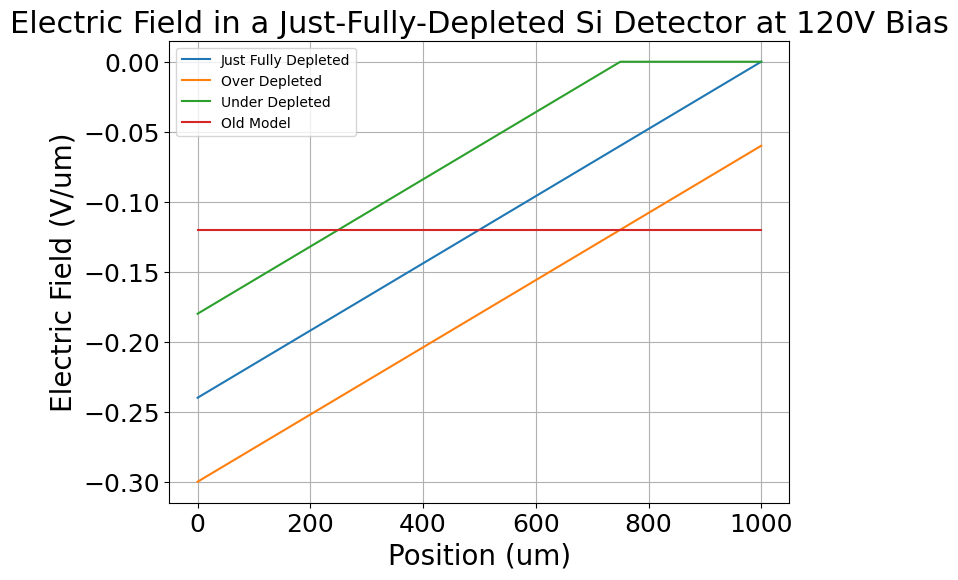

In [13]:
class E_field:
    def __init__(self, m, b, d, name='E field'):
        self.m = m
        self.b = b
        self.d = d
        x_int_padded = -b/m - 1e-9
        self.d_eff = min(x_int_padded, d)
        self.name = name
        
    def get_e_field(self, x):
        e_field = self.m * x + self.b
        mask = x <= self.d_eff
        return e_field * mask
    
    
full_depletion = E_field(field_slope, field_intercept, DET_DEPTH, 'full depletion')
over_depletion = E_field(field_slope, 1.25*field_intercept, DET_DEPTH, 'over-depletion')
under_depletion = E_field(field_slope, .75*field_intercept, DET_DEPTH, 'under-depletion')

flat_field_mag = V_DEPLETION / DET_DEPTH
old_model = E_field(0.001, -flat_field_mag, DET_DEPTH, 'old model')

x=np.linspace(xg, xv, 1000)  # m
ef = full_depletion.get_e_field(x) # V/m
og = over_depletion.get_e_field(x) # V/m
ug = under_depletion.get_e_field(x) # V/m
old = old_model.get_e_field(x) # V/m
plt.plot(x*1e6, ef*1e-6, label='Just Fully Depleted')
plt.plot(x*1e6, og*1e-6, label='Over Depleted')
plt.plot(x*1e6, ug*1e-6, label='Under Depleted')
plt.plot(x*1e6, old*1e-6, label='Old Model')
plt.legend()
plt.xlabel('Position (um)')
plt.ylabel('Electric Field (V/um)')
plt.title('Electric Field in a Just-Fully-Depleted Si Detector at 120V Bias')
plt.grid()

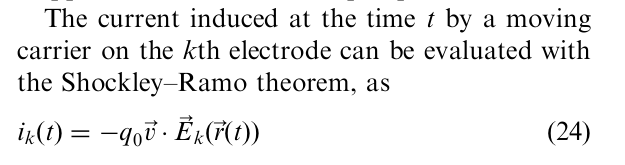
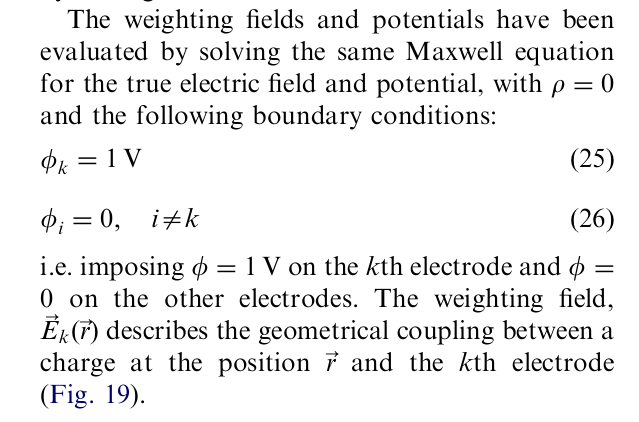

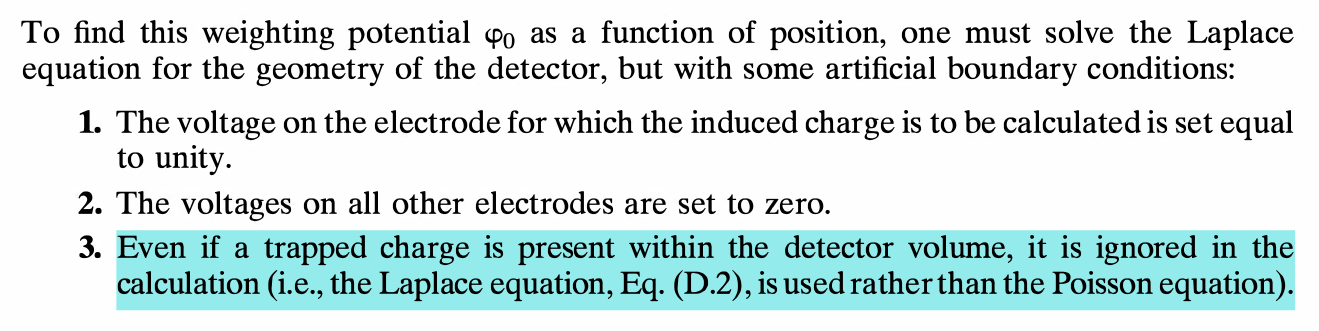

This is explained better here: https://doi.org/10.1016/S0168-9002(01)00223-6

For us the weighting field is then constant.

In [14]:
# *flag for permittivity
WEIGHTING_FIELD = 1 / DET_DEPTH # 1/m

### Charge Carrier Trajectory Solution: ###

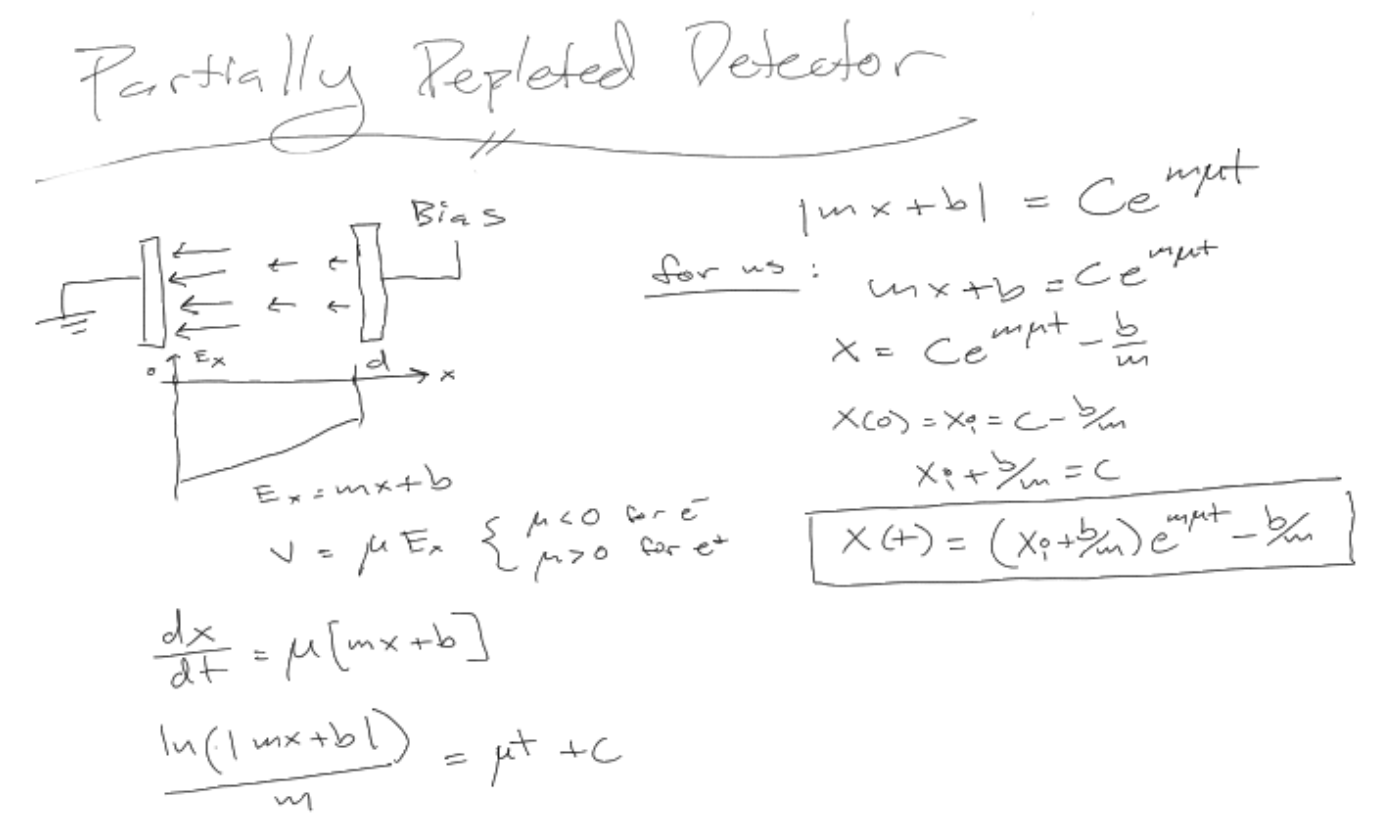

### Collection time Solution: ###

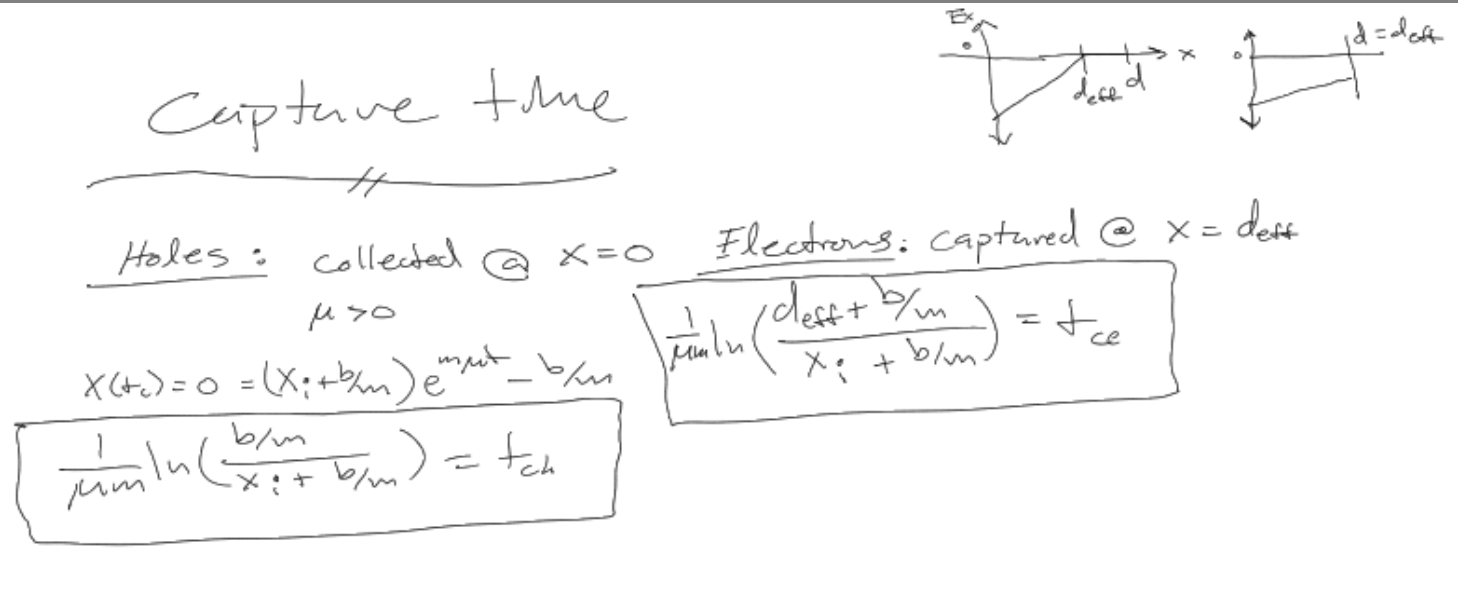

moving to back
moving to front
moving to back
moving to front
moving to back
moving to front
moving to back
moving to front


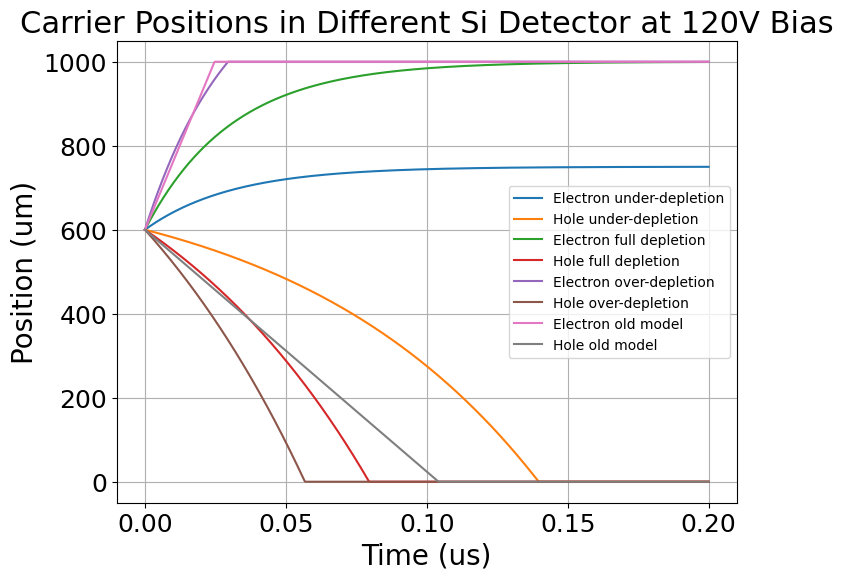

In [15]:
def get_tc(m, b, mu, x_init, d_eff, final_dest='back'):
    if final_dest == 'back':
        tc = (1 / (mu * m)) * np.log((b / m + d_eff) / (b / m + x_init))
    elif final_dest == 'front':
        tc = (1 / (mu * m)) * np.log((b / m) / (b / m + x_init))
    return tc

def carrier_x(t, m, b, mu, x_init, d_eff):
    if x_init > d_eff:
        x = np.full_like(t, x_init)
        return x
    else: 
        x = (x_init + b/m) * np.exp(mu*m*t) - b/m
        travel = (x[-1] - x[0])
        if travel > 0:
            # moving toward back contact
            final_dest = 'back'
            fill_in = d_eff
            print('moving to back')
        else:
            # moving toward front contact
            final_dest = 'front'
            fill_in = 0
            print('moving to front')

        tc = get_tc(m, b, mu, x_init, d_eff, final_dest=final_dest)
        return np.where(t <= tc, x, fill_in)

time = np.linspace(0, 200e-9, 1000)  # s

for field in [under_depletion, full_depletion, over_depletion, old_model]:
    x_e = carrier_x(time, field.m, field.b, MOBILITIES['electron']['room temperature'], 600e-6, field.d_eff)
    x_h = carrier_x(time, field.m, field.b, MOBILITIES['hole']['room temperature'], 600e-6, field.d_eff)
    plt.plot(time*1e6, x_e*1e6, label=f'Electron {field.name}')
    plt.plot(time*1e6, x_h*1e6, label=f'Hole {field.name}')


plt.xlabel('Time (us)')
plt.ylabel('Position (um)')
plt.title('Carrier Positions in Different Si Detector at 120V Bias')
plt.legend()
# plt.ylim(0,1000)
plt.grid()

### Velocity of Charge Carrier Solution ###
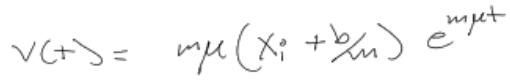

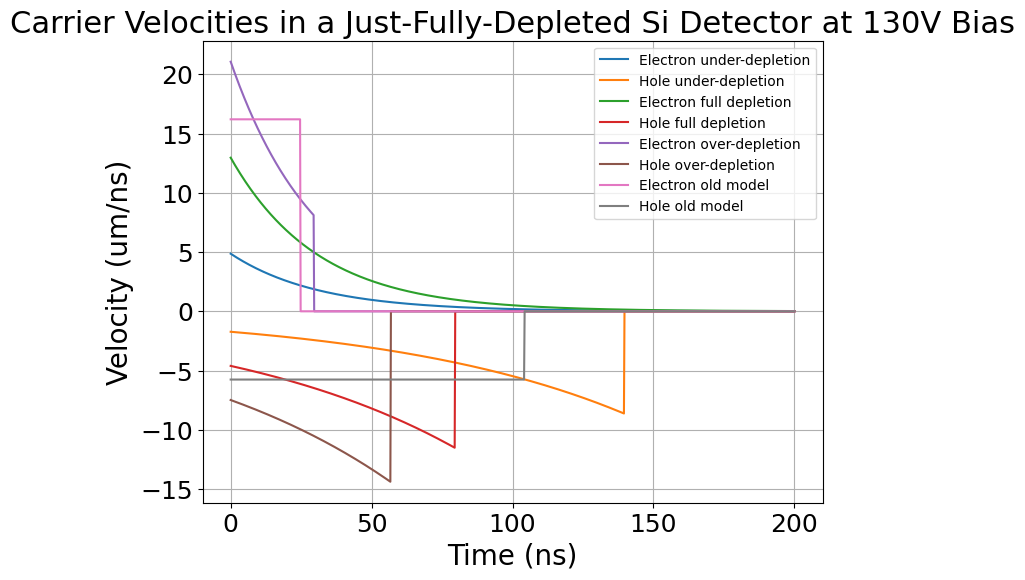

In [16]:
def get_velocity(t, m, b, mu, x_init, d_eff):
    if x_init > d_eff:
        velocity = np.zeros_like(t)
        return velocity
    else:
        velocity = mu*m*(b/m + x_init)*np.exp(mu*m*t)
        if velocity[2] < 0:
            final_dest = 'front'
        else: 
            final_dest = 'back'
        mask = t <= get_tc(m, b, mu, x_init, d_eff=d_eff, final_dest=final_dest)
        return velocity * mask

for field in [under_depletion, full_depletion, over_depletion, old_model]:
    vel_e = get_velocity(time, field.m, field.b, MOBILITIES['electron']['room temperature'], 600e-6, field.d_eff)
    vel_h = get_velocity(time, field.m, field.b, MOBILITIES['hole']['room temperature'], 600e-6, field.d_eff)
    plt.plot(time*1e9, vel_e*1e-3, label=f'Electron {field.name}')
    plt.plot(time*1e9, vel_h*1e-3, label=f'Hole {field.name}')
plt.xlabel('Time (ns)')
plt.ylabel('Velocity (um/ns)')
plt.title('Carrier Velocities in a Just-Fully-Depleted Si Detector at 130V Bias')
plt.legend()
plt.grid()


### Shockley - Ramo formula adapted for our detector geometry ###

(Weighting Field is Constant for Parallel Plate, 2 Contact Geometry)


 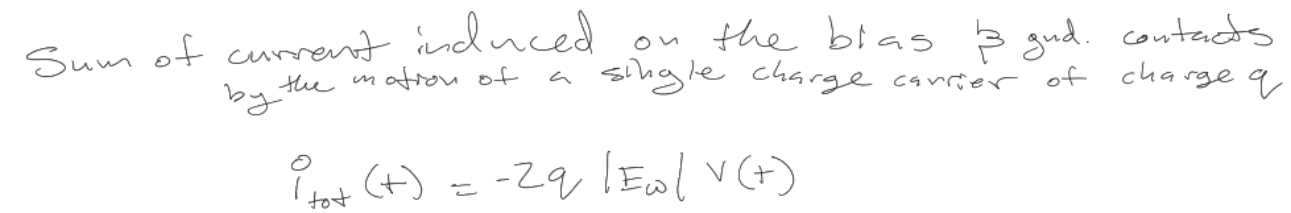

In [17]:
### Global Constants ###
K = 1.38e-23         # Boltzmann constant (J/K)
T = 300             # temperature (K)
CHARGE = 1.6e-19    # electron charge (C)
PAIR_CREATION_E = 3.62e-3  # pair creation energy in Si (keV)

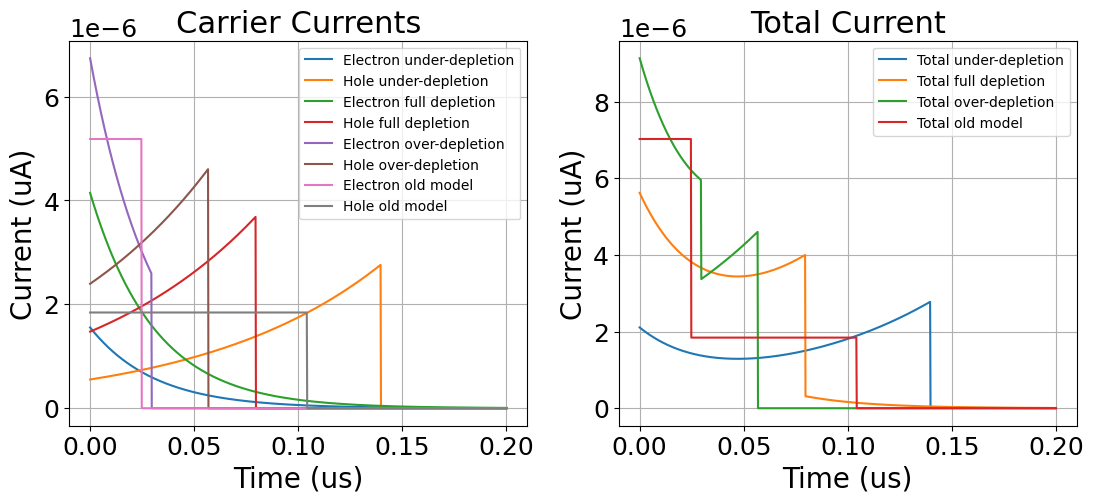

In [18]:
def instantaneous_current(t, m, b, mu, x_init, d_eff, weighting_field):
    v_drift = get_velocity(t, m, b, mu, x_init, d_eff)
    return -2 * np.sign(mu) * CHARGE * weighting_field * v_drift



fig, ax = plt.subplots(1, 2, figsize=(13, 5))
for field in [under_depletion, full_depletion, over_depletion, old_model]:
    i_e = instantaneous_current(time, field.m, field.b, MOBILITIES['electron']['room temperature'], 600e-6, field.d_eff, WEIGHTING_FIELD)
    i_h = instantaneous_current(time, field.m, field.b, MOBILITIES['hole']['room temperature'], 600e-6, field.d_eff, WEIGHTING_FIELD)
    ax[0].plot(time*1e6, i_e*1e6, label=f'Electron {field.name}')
    ax[0].plot(time*1e6, i_h*1e6, label=f'Hole {field.name}')
    ax[1].plot(time*1e6, (i_e+i_h)*1e6, label=f'Total {field.name}')
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Current (uA)')
ax[0].set_title('Carrier Currents')
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Current (uA)')
ax[1].set_title('Total Current')
ax[1].legend()
ax[1].grid()

In [19]:
def generate_global_detector_response(detector_axis, time_axis, e_field, mu, weighting_field):
    """ Generates an array where each ____ index corresponds to an inital x position of an electron or hole
    and each ___ index corresponds to a time, such that each ____ contatins the total current respose for each initial condition"""
    if e_field.d != detector_axis[-1]:
        print('Warning: E field d and detector_axis d do not match!')
    
    current_response_array = np.zeros((len(detector_axis), len(time_axis)))
    for i, x_init in enumerate(detector_axis):
        current_response_array[i, :] = instantaneous_current(time_axis, e_field.m, e_field.b, mu, x_init, e_field.d_eff, weighting_field)
        
    return current_response_array

# come back to later if speed becomes issue
# def gen_glob_det_resp(detector_axis, time_axis, e_field, mu, weighting_field):
#     x_init = detector_axis[:, np.newaxis]
#     t = time_axis[np.newaxis, :]

#     return instantaneous_current(t, e_field.m, e_field.b, mu, x_init, e_field.d_eff, weighting_field)


In [20]:
time_test = np.linspace(0, 0.25e-6, 100)
detector_test = np.linspace(0, DET_DEPTH, 1000)

In [21]:
PAIR_CREATION_E = 3.62e-3  # pair creation energy in Si (keV)

In [22]:
def generate_gauss_deposition(detector_axis, mean, std_dev, deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.normal(mean, std_dev, num_positions)
    print(np.shape(x_positions))
    # make bin edges
    half_step = (detector_axis[1] - detector_axis[0]) / 2
    bins = np.concatenate([[-half_step], detector_axis+half_step])
    counts, _ = np.histogram(x_positions, bins=bins)
    print(np.shape(counts))
    return counts

def generate_beta_deposition(detector_axis, deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.uniform(xg, xv, num_positions)
    # make bin edges
    half_step = (detector_axis[1] - detector_axis[0]) / 2
    bins = np.concatenate([[-half_step],
                            detector_axis+half_step])
    counts, _ = np.histogram(x_positions, bins=bins)
    return counts

(16574,)
(1000,)


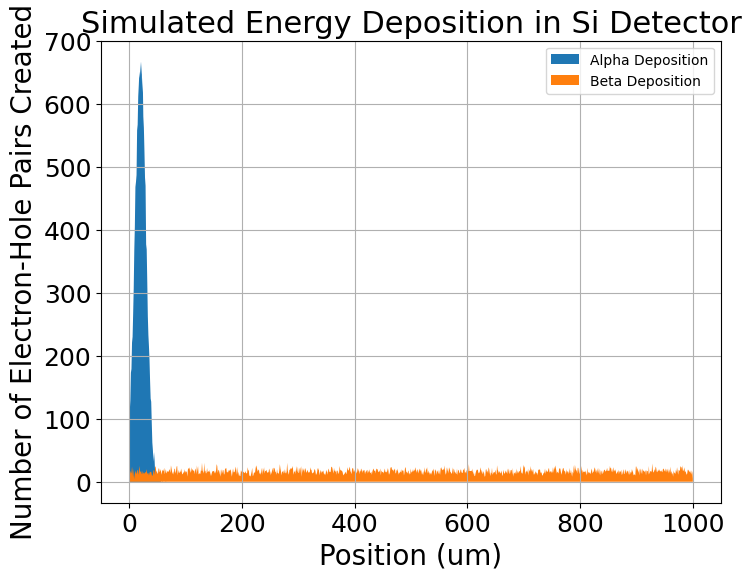

In [23]:
dep_energy = 60 # keV
a_counts = generate_gauss_deposition(detector_test, 20e-6, 10e-6, dep_energy)  
b_counts = generate_beta_deposition(detector_test, dep_energy) 

plt.fill_between(detector_test*1e6, 0, a_counts, label='Alpha Deposition')
plt.fill_between(detector_test*1e6, 0, b_counts, label='Beta Deposition')
plt.xlabel('Position (um)')
plt.ylabel('Number of Electron-Hole Pairs Created')
plt.title('Simulated Energy Deposition in Si Detector')
plt.legend()
plt.grid()

In [24]:
def simulate_event(response_array, weighting_population):
    weighted_response_array = response_array * weighting_population[:, np.newaxis]
    full_response = np.sum(weighted_response_array, axis=0)
    return full_response


def integrate_current(current, time):
    result = sp.integrate.cumulative_trapezoid(current, time)
    result = np.insert(result, 0, 0)
    return result

In [25]:
e_under = generate_global_detector_response(detector_test, time_test, under_depletion, MOBILITIES['electron']['room temperature'], WEIGHTING_FIELD)
h_under = generate_global_detector_response(detector_test, time_test, under_depletion, MOBILITIES['hole']['room temperature'], WEIGHTING_FIELD)

e_full = generate_global_detector_response(detector_test, time_test, full_depletion, MOBILITIES['electron']['room temperature'], WEIGHTING_FIELD)
h_full = generate_global_detector_response(detector_test, time_test, full_depletion, MOBILITIES['hole']['room temperature'], WEIGHTING_FIELD)

e_over = generate_global_detector_response(detector_test, time_test, over_depletion, MOBILITIES['electron']['room temperature'], WEIGHTING_FIELD)
h_over = generate_global_detector_response(detector_test, time_test, over_depletion, MOBILITIES['hole']['room temperature'], WEIGHTING_FIELD)

e_old = generate_global_detector_response(detector_test, time_test, old_model, MOBILITIES['electron']['room temperature'], WEIGHTING_FIELD)
h_old = generate_global_detector_response(detector_test, time_test, old_model, MOBILITIES['hole']['room temperature'], WEIGHTING_FIELD)

In [26]:
model_responses = [   [e_under, h_under],
                [e_full, h_full],
                [e_over, h_over],
                [e_old, h_old]
             ]

e_fields = [under_depletion, full_depletion, over_depletion, old_model]

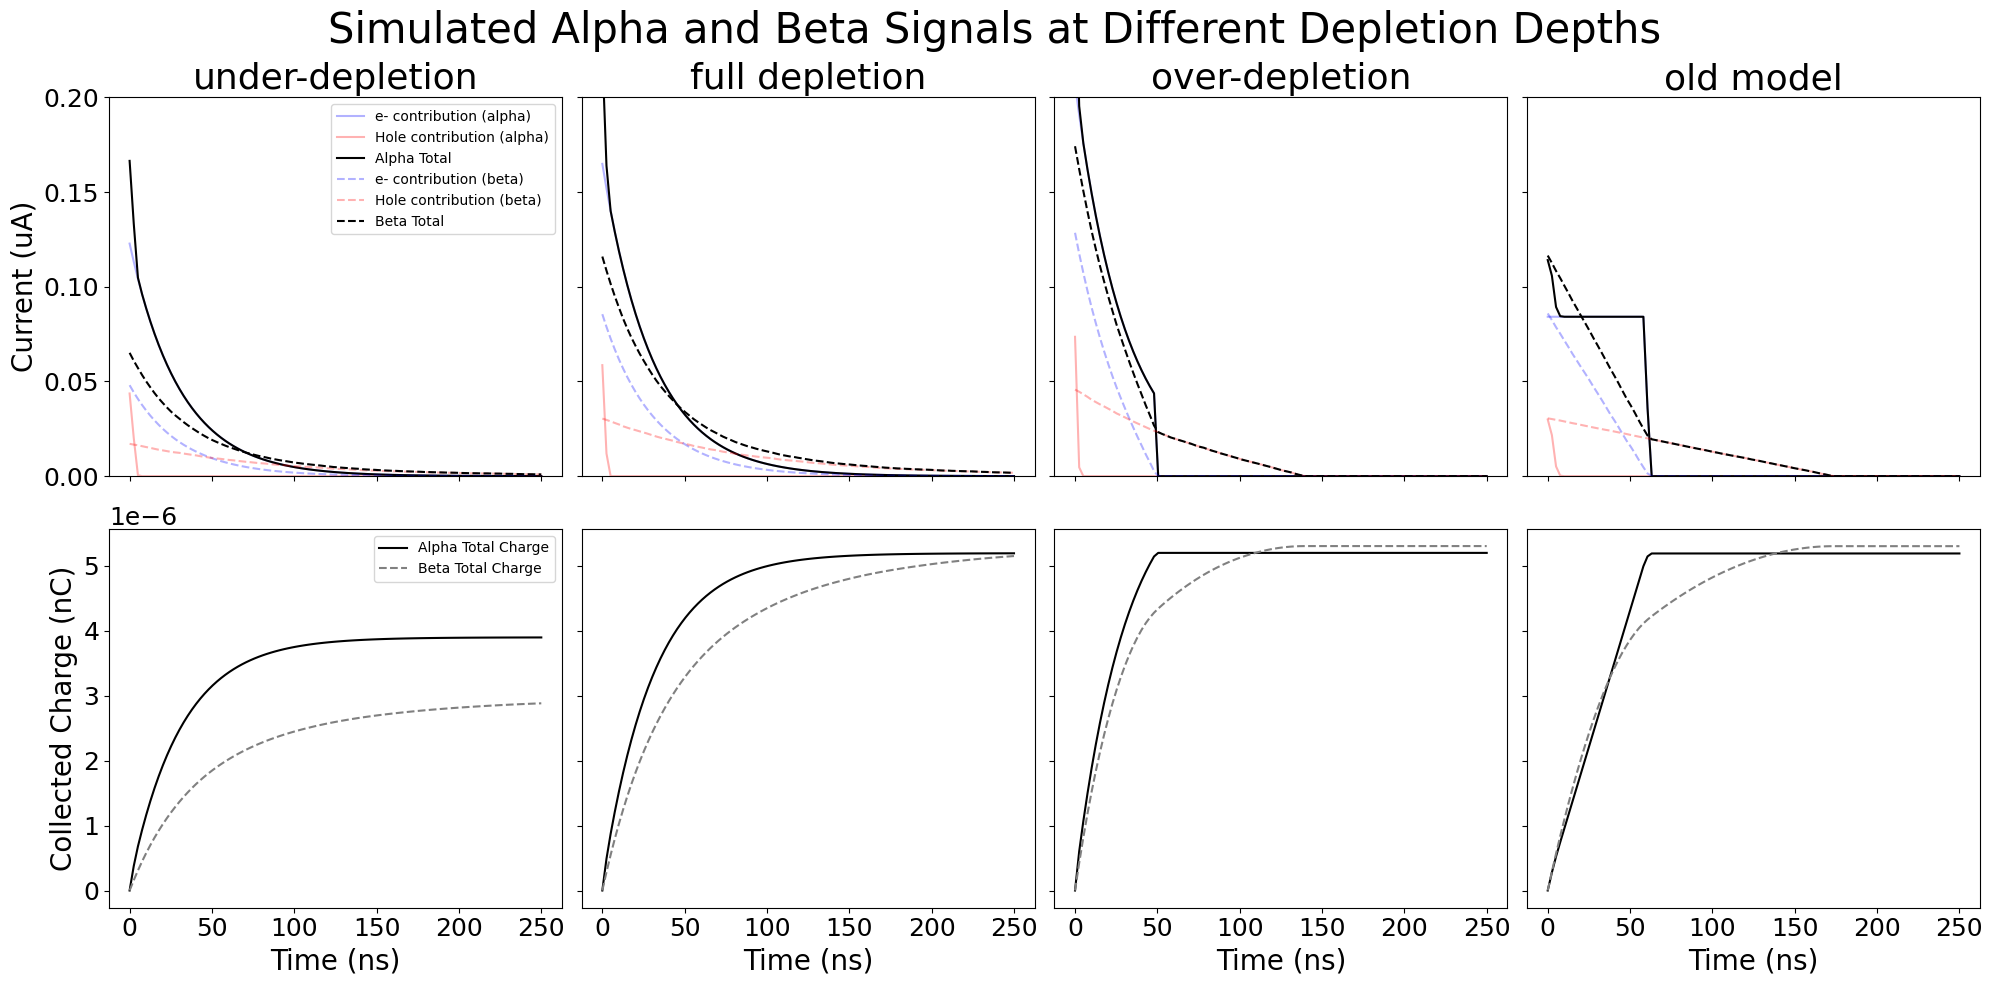

In [27]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey='row',figsize=(20, 10))

for i, model in enumerate(model_responses):
    # calculate alphas
    alpha_e = simulate_event(model[0], a_counts)
    alpha_h = simulate_event(model[1], a_counts)
    alpha_sum = alpha_e + alpha_h
    alpha_charge = integrate_current(alpha_sum, time_test)

    # calculate betas
    beta_e = simulate_event(model[0], b_counts)
    beta_h = simulate_event(model[1], b_counts)
    beta_sum = beta_e + beta_h
    beta_charge = integrate_current(beta_sum, time_test)

    i_scale_fact = 1e6 # to convert to uA
    ax[0, i].plot(time_test*1e9, alpha_e*i_scale_fact, label='e- contribution (alpha)', alpha=0.3, color='blue')
    ax[0, i].plot(time_test*1e9, alpha_h*i_scale_fact, label='Hole contribution (alpha)', alpha=0.3, color='red')
    ax[0, i].plot(time_test*1e9, alpha_sum*i_scale_fact, label='Alpha Total', color='black')

    ax[0, i].plot(time_test*1e9, beta_e*i_scale_fact, label='e- contribution (beta)', alpha=0.3, linestyle='--', color='blue')
    ax[0, i].plot(time_test*1e9, beta_h*i_scale_fact, label='Hole contribution (beta)', alpha=0.3, linestyle='--', color='red')
    ax[0, i].plot(time_test*1e9, beta_sum*i_scale_fact, label='Beta Total', linestyle='--', color='black')

    ax[0, i].set_title(f'{e_fields[i].name}', fontsize=26)

    ax[1, i].plot(time_test*1e9, alpha_charge*1e9, label='Alpha Total Charge', color='black')
    ax[1, i].plot(time_test*1e9, beta_charge*1e9, label='Beta Total Charge', linestyle='--', color='gray')
    ax[1, i].set_xlabel('Time (ns)')


ax[0, 0].set_ylim(0,0.2)
ax[0, 0].set_ylabel('Current (uA)')
ax[1, 0].set_ylabel('Collected Charge (nC)')
ax[0, 0].legend()
ax[1, 0].legend()

fig.suptitle('Simulated Alpha and Beta Signals at Different Depletion Depths', fontsize=30)
fig.tight_layout()


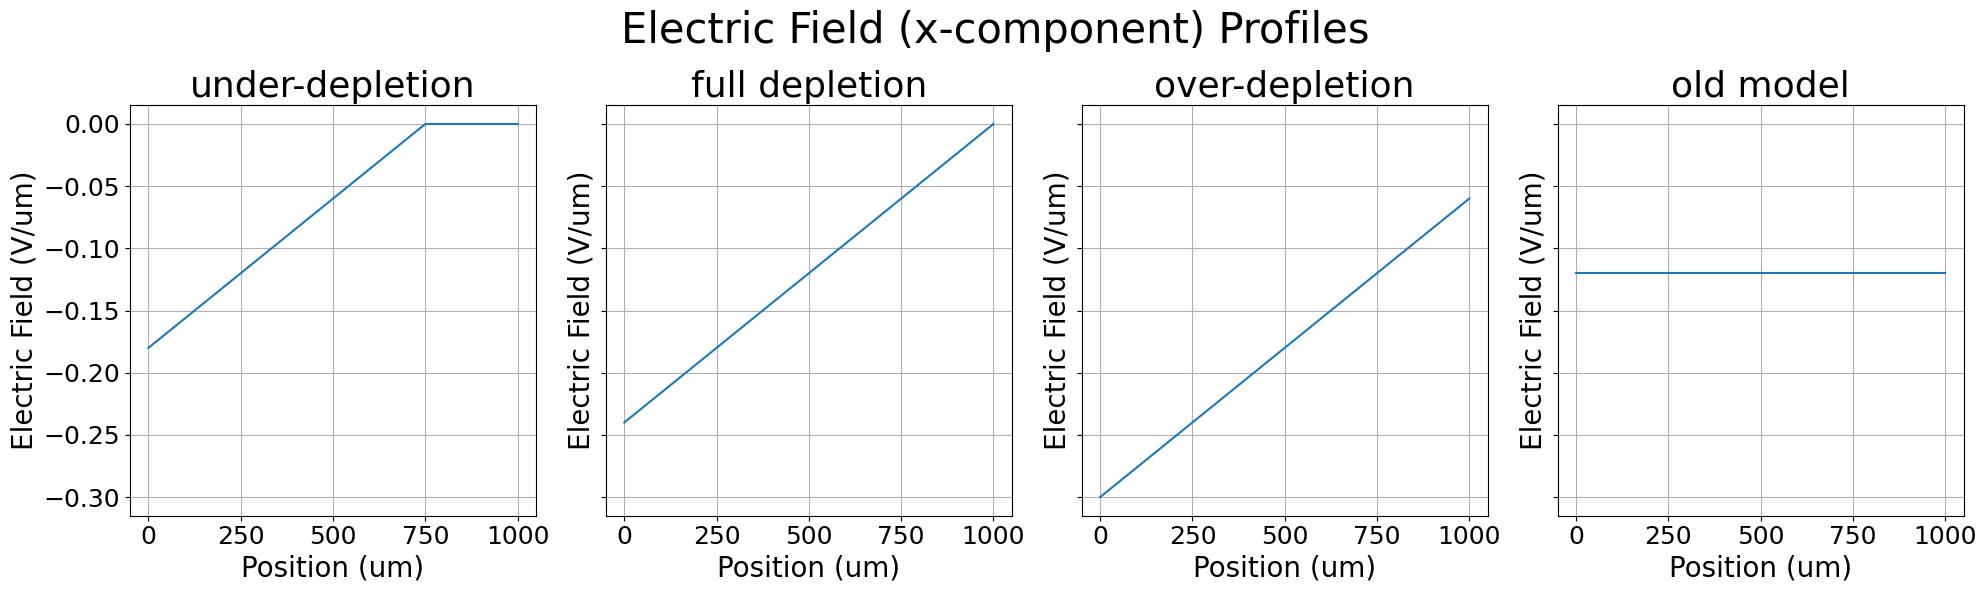

In [28]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(20, 6))

for i, model in enumerate(e_fields):
    e_field = model.get_e_field(detector_test)
    ax[i].plot(detector_test*1e6, e_field*1e-6)
    ax[i].set_xlabel('Position (um)')
    ax[i].set_ylabel('Electric Field (V/um)')
    ax[i].set_title(f'{model.name}', fontsize=26)
    ax[i].grid()
fig.suptitle('Electric Field (x-component) Profiles', fontsize=30)
plt.tight_layout()


In [36]:
cryo_time = np.linspace(0, 20e-9, 100)


In [37]:
cryo_e_under = generate_global_detector_response(detector_test, cryo_time, under_depletion, MOBILITIES['electron']['cryogenic'], WEIGHTING_FIELD)
cryo_h_under = generate_global_detector_response(detector_test, cryo_time, under_depletion, MOBILITIES['hole']['cryogenic'], WEIGHTING_FIELD)

cryo_e_full = generate_global_detector_response(detector_test, cryo_time, full_depletion, MOBILITIES['electron']['cryogenic'], WEIGHTING_FIELD)
cryo_h_full = generate_global_detector_response(detector_test, cryo_time, full_depletion, MOBILITIES['hole']['cryogenic'], WEIGHTING_FIELD)

cryo_e_over = generate_global_detector_response(detector_test, cryo_time, over_depletion, MOBILITIES['electron']['cryogenic'], WEIGHTING_FIELD)
cryo_h_over = generate_global_detector_response(detector_test, cryo_time, over_depletion, MOBILITIES['hole']['cryogenic'], WEIGHTING_FIELD)

cryo_e_old = generate_global_detector_response(detector_test, cryo_time, old_model, MOBILITIES['electron']['cryogenic'], WEIGHTING_FIELD)
cryo_h_old = generate_global_detector_response(detector_test, cryo_time, old_model, MOBILITIES['hole']['cryogenic'], WEIGHTING_FIELD)

cryo_model_responses = [   [cryo_e_under, cryo_h_under],
                [cryo_e_full, cryo_h_full],
                [cryo_e_over, cryo_h_over],
                [cryo_e_old, cryo_h_old]
             ]


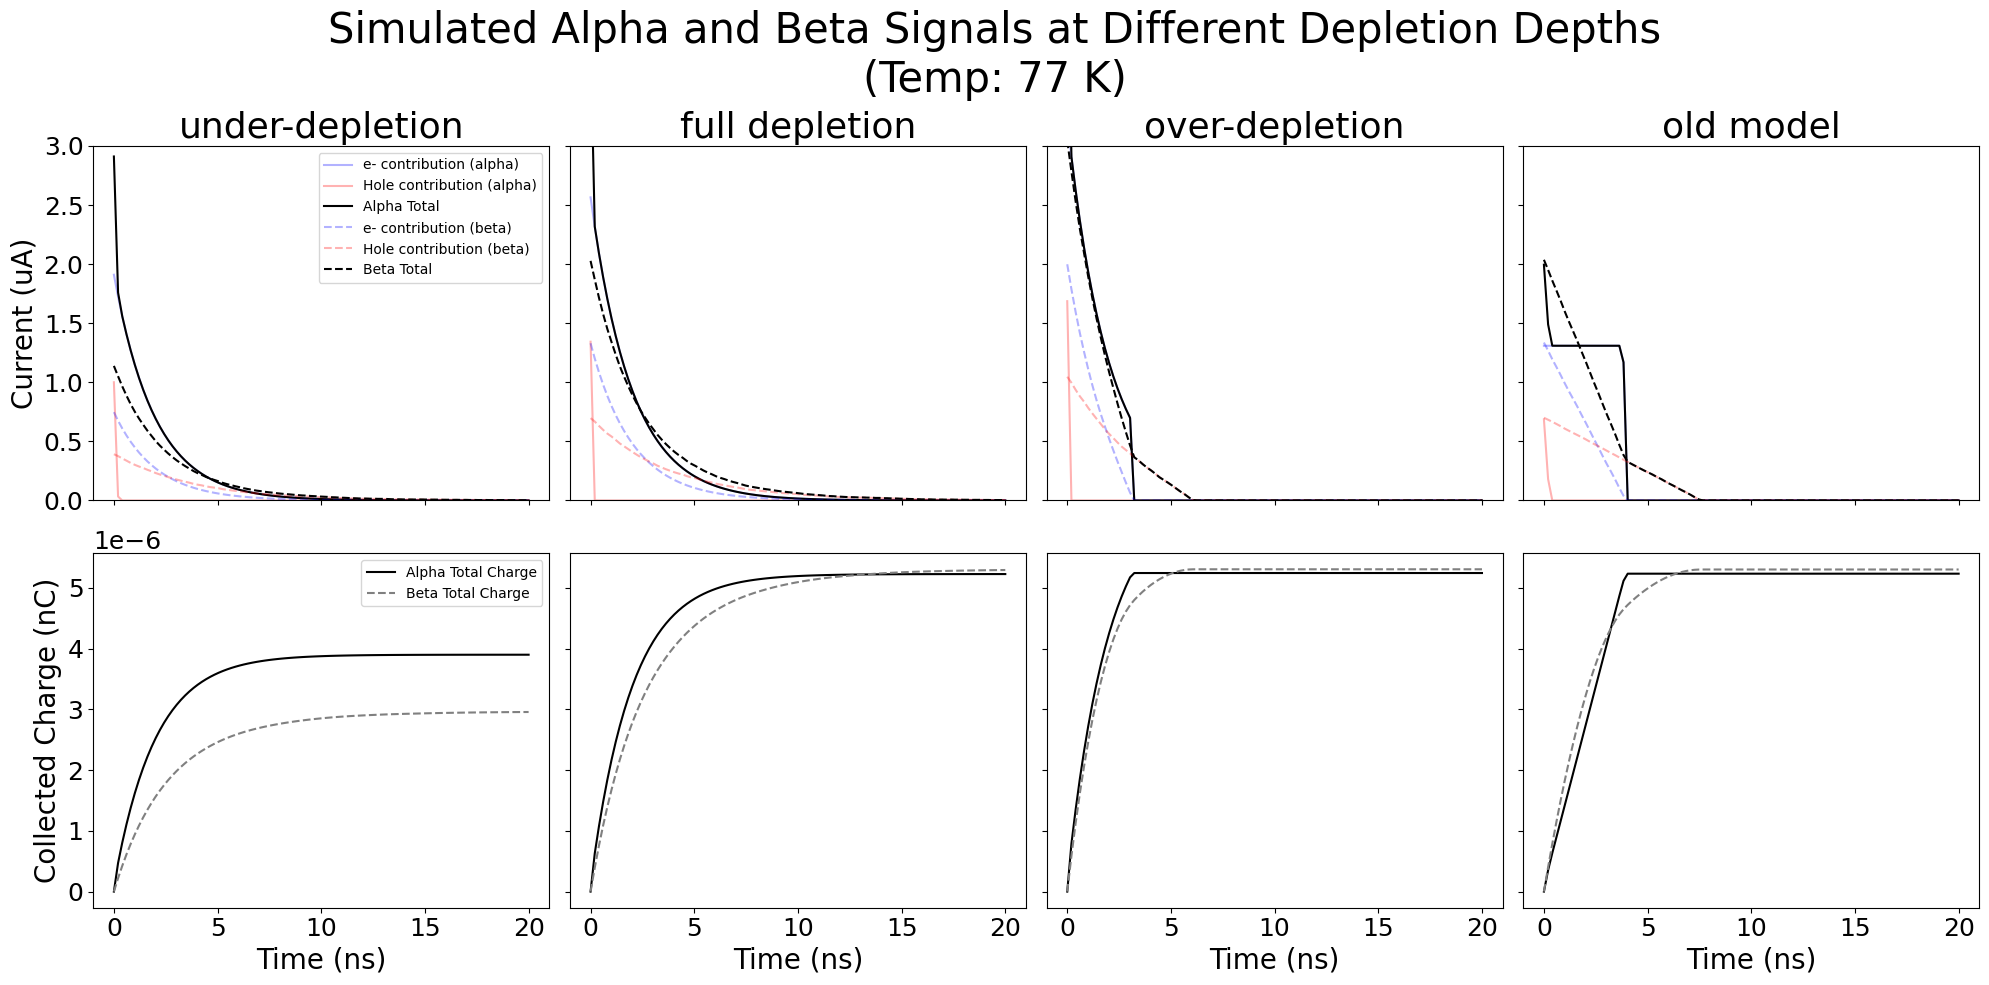

In [41]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey='row',figsize=(20, 10))

for i, model in enumerate(cryo_model_responses):
    # calculate alphas
    alpha_e = simulate_event(model[0], a_counts)
    alpha_h = simulate_event(model[1], a_counts)
    alpha_sum = alpha_e + alpha_h
    alpha_charge = integrate_current(alpha_sum, cryo_time)

    # calculate betas
    beta_e = simulate_event(model[0], b_counts)
    beta_h = simulate_event(model[1], b_counts)
    beta_sum = beta_e + beta_h
    beta_charge = integrate_current(beta_sum, cryo_time)

    i_scale_fact = 1e6 # to convert to uA
    ax[0, i].plot(cryo_time*1e9, alpha_e*i_scale_fact, label='e- contribution (alpha)', alpha=0.3, color='blue')
    ax[0, i].plot(cryo_time*1e9, alpha_h*i_scale_fact, label='Hole contribution (alpha)', alpha=0.3, color='red')
    ax[0, i].plot(cryo_time*1e9, alpha_sum*i_scale_fact, label='Alpha Total', color='black')

    ax[0, i].plot(cryo_time*1e9, beta_e*i_scale_fact, label='e- contribution (beta)', alpha=0.3, linestyle='--', color='blue')
    ax[0, i].plot(cryo_time*1e9, beta_h*i_scale_fact, label='Hole contribution (beta)', alpha=0.3, linestyle='--', color='red')
    ax[0, i].plot(cryo_time*1e9, beta_sum*i_scale_fact, label='Beta Total', linestyle='--', color='black')

    ax[0, i].set_title(f'{e_fields[i].name}', fontsize=26)

    ax[1, i].plot(cryo_time*1e9, alpha_charge*1e9, label='Alpha Total Charge', color='black')
    ax[1, i].plot(cryo_time*1e9, beta_charge*1e9, label='Beta Total Charge', linestyle='--', color='gray')
    ax[1, i].set_xlabel('Time (ns)')


ax[0, 0].set_ylim(0,3)
ax[0, 0].set_ylabel('Current (uA)')
ax[1, 0].set_ylabel('Collected Charge (nC)')
ax[0, 0].legend()
ax[1, 0].legend()

fig.suptitle('Simulated Alpha and Beta Signals at Different Depletion Depths\n(Temp: 77 K)', fontsize=30)
fig.tight_layout()


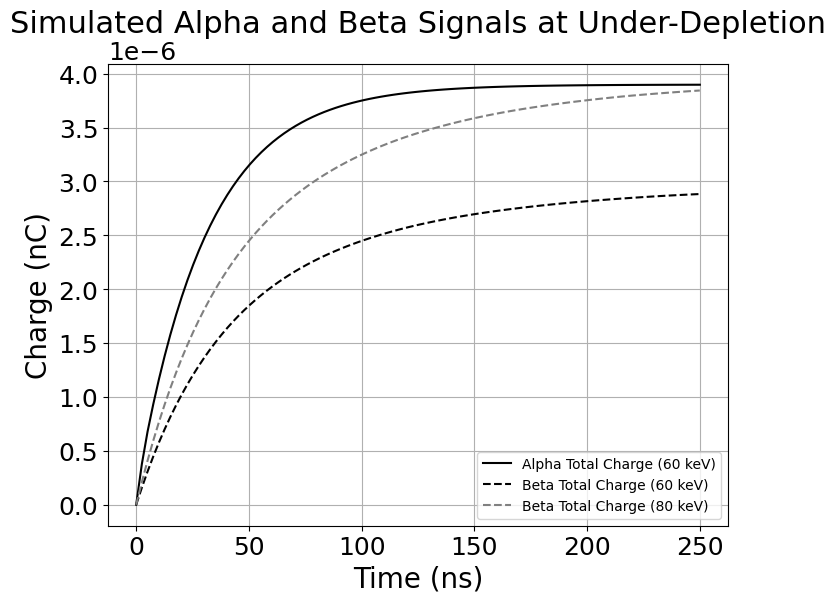

In [50]:
model = model_responses[0]  # under depletion

# calculate alphas
alpha_e = simulate_event(model[0], a_counts)
alpha_h = simulate_event(model[1], a_counts)
alpha_sum = alpha_e + alpha_h
alpha_charge = integrate_current(alpha_sum, time_test)

# calculate betas
beta_e = simulate_event(model[0], b_counts)
beta_h = simulate_event(model[1], b_counts)
beta_sum = beta_e + beta_h
beta_charge = integrate_current(beta_sum, time_test)

E_choice = 80  # keV
beta_counts_more = generate_beta_deposition(detector_test, E_choice) 
beta_e_more = simulate_event(model[0], beta_counts_more)
beta_h_more = simulate_event(model[1], beta_counts_more)
beta_sum_more = beta_e_more + beta_h_more
beta_charge_more = integrate_current(beta_sum_more, time_test)

plt.plot(time_test*1e9, alpha_charge*1e9, label='Alpha Total Charge (60 keV)', color='black')
plt.plot(time_test*1e9, beta_charge*1e9, label='Beta Total Charge (60 keV)', color='black', linestyle='--')
plt.plot(time_test*1e9, beta_charge_more*1e9, label=f'Beta Total Charge ({E_choice} keV)', color='gray', linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('Charge (nC)')
plt.title('Simulated Alpha and Beta Signals at Under-Depletion')
plt.legend()
plt.grid()

